In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold



In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Data import and EDA

In [3]:
marketing = pd.read_csv('./bank_marketing.csv')

In [4]:
marketing.shape

(41188, 21)

In [5]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
response          41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [6]:
marketing.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
marketing.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
response          0
dtype: int64

In [8]:
marketing.response.value_counts()

no     36548
yes     4640
Name: response, dtype: int64

### map response yes,no to 0,1

In [9]:
marketing.response = marketing.response.map({'yes':1,'no':0})

In [10]:
print(round(100*marketing.response.sum()/len(marketing),2))

11.27


## Age

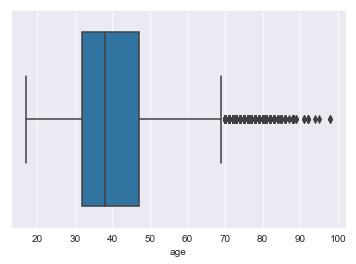

In [11]:
sns.boxplot(x='age',data = marketing)
plt.show()

In [12]:
marketing.age.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
90%         55.00000
95%         58.00000
99%         71.00000
max         98.00000
Name: age, dtype: float64

we can see that there are outliers present from the boxplot, hence we are going to impute the data to remove outliers. we are going to set all the values that are greater than 99 percentile to 99 percentile value i.e 71

In [13]:
marketing.loc[marketing.age>71,'age'] = 71

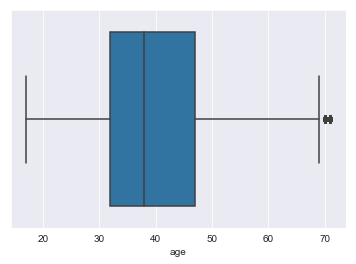

In [14]:
sns.boxplot(x='age',data=marketing)
plt.show()

In [15]:
# To understand the behaviour of people with age, we are going to bucket the age groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,marketing['age'].max() + 10, 10)
marketing['age_bins'] = pd.cut(marketing['age'], bins, include_lowest=True)
No_of_prospect = marketing.groupby('age_bins')['response'].count().reset_index(name = 'No.of_prospect')
count_prospects = marketing[marketing['response']==1].groupby('age_bins')['response'].count().reset_index(name = 'count_prospects')
agg_age = No_of_prospect.merge(count_prospects, on='age_bins')
agg_age['response_rate'] = 100*(agg_age['count_prospects']/agg_age['No.of_prospect']).round(3)
agg_age

,age_bins,No.of_prospect,count_prospects,response_rate
0,"(9.999, 20.0]",140,57,40.7
1,"(20.0, 30.0]",7243,1067,14.7
2,"(30.0, 40.0]",16385,1597,9.7
3,"(40.0, 50.0]",10240,837,8.2
4,"(50.0, 60.0]",6270,668,10.7
5,"(60.0, 70.0]",488,212,43.4
6,"(70.0, 80.0]",422,202,47.9


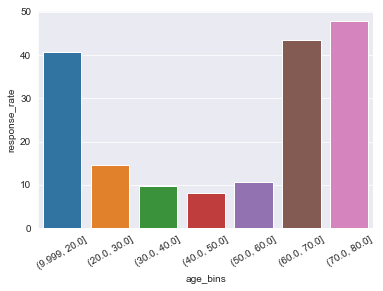

In [16]:
ax = sns.barplot(x='age_bins', y='response_rate', data=agg_age)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

The youngest and the older seem to be positively to the campaign than the other age groups

## job

In [17]:
print(marketing.job.value_counts())
print('*'*40)
print(round(100*marketing.job.value_counts()/len(marketing),2))

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
****************************************
admin.           25.30
blue-collar      22.47
technician       16.37
services          9.64
management        7.10
retired           4.18
entrepreneur      3.54
self-employed     3.45
housemaid         2.57
unemployed        2.46
student           2.12
unknown           0.80
Name: job, dtype: float64


In [18]:
count_prospects_job = marketing.groupby('job')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_job = marketing.groupby('job')['response'].count().reset_index(name = 'No_of_prospects')
agg_job = count_prospects_job.merge(No_of_prospect_job, on = 'job')
agg_job['response_rate'] = 100*(agg_job['count_prospects']/agg_job['No_of_prospects']).round(4)
agg_job

,job,count_prospects,No_of_prospects,response_rate
0,admin.,1352,10422,12.97
1,blue-collar,638,9254,6.89
2,entrepreneur,124,1456,8.52
3,housemaid,106,1060,10.00
4,management,328,2924,11.22
5,retired,434,1720,25.23
6,self-employed,149,1421,10.49
7,services,323,3969,8.14
8,student,275,875,31.43
9,technician,730,6743,10.83


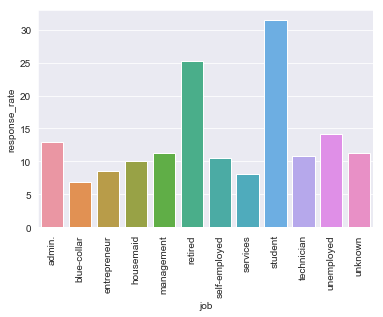

In [19]:
ax = sns.barplot(x='job', y='response_rate', data=agg_job)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

we can see that retired and students have higher response rate than the other job types. This is similar to what we have observed in the age variable.

## Marital

In [20]:
print(marketing.marital.value_counts())
print('*'*40)
print(round(100*marketing.marital.value_counts()/len(marketing),2))

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
****************************************
married     60.52
single      28.09
divorced    11.20
unknown      0.19
Name: marital, dtype: float64


Since there are 80 entries which list marital status as 'unknown', we will assign them to the biggest group, which is, 'married'.

In [21]:
marketing.replace({'marital' : { 'unknown' : 'married'}}, inplace=True)

count_prospects_marital = marketing.groupby('marital')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_job = marketing.groupby('marital')['response'].count().reset_index(name = 'No_of_prospects')
agg_marital = count_prospects_marital.merge(No_of_prospect_job, on = 'marital')
agg_marital['response_rate'] = 100*(agg_marital['count_prospects']/agg_marital['No_of_prospects']).round(4)
agg_marital

,marital,count_prospects,No_of_prospects,response_rate
0,divorced,476,4612,10.32
1,married,2544,25008,10.17
2,single,1620,11568,14.00


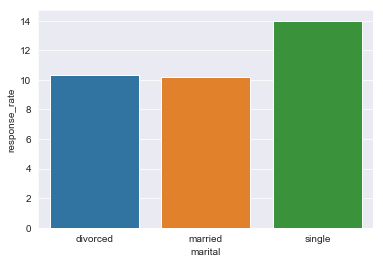

In [22]:
ax = sns.barplot(x='marital', y='response_rate', data=agg_marital)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

You may note that there is a slight uptick in response rate for single customers, this can be attributed in part to the fact that people under the age of 20 have a very high response rate. 

## Education

In [23]:
print(marketing.education.value_counts())
print('*'*40)
print(round(100*marketing.education.value_counts()/len(marketing),2))

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
****************************************
university.degree      29.54
high.school            23.10
basic.9y               14.68
professional.course    12.73
basic.4y               10.14
basic.6y                5.56
unknown                 4.20
illiterate              0.04
Name: education, dtype: float64


In [24]:
# bucketing the education types in to smaller groups for easier analysis
marketing.replace({'education' : { 'basic.9y' : 'Primary_Education', 'basic.4y' : 'Primary_Education','basic.6y' : 'Primary_Education','illiterate' : 'Primary_Education',
                             'high.school' : 'Secondary_Education', 'university.degree' : 'Tertiary_Education' }}, inplace=True)

In [25]:
print(marketing.education.value_counts())
print('*'*40)
print(round(100*marketing.education.value_counts()/len(marketing),2))

Primary_Education      12531
Tertiary_Education     12168
Secondary_Education     9515
professional.course     5243
unknown                 1731
Name: education, dtype: int64
****************************************
Primary_Education      30.42
Tertiary_Education     29.54
Secondary_Education    23.10
professional.course    12.73
unknown                 4.20
Name: education, dtype: float64


In [26]:
count_prospects_education = marketing.groupby('education')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_education = marketing.groupby('education')['response'].count().reset_index(name = 'No_of_prospects')
agg_education = count_prospects_education.merge(No_of_prospect_education, on = 'education')
agg_education['response_rate'] = 100*(agg_education['count_prospects']/agg_education['No_of_prospects']).round(4)
agg_education

,education,count_prospects,No_of_prospects,response_rate
0,Primary_Education,1093,12531,8.72
1,Secondary_Education,1031,9515,10.84
2,Tertiary_Education,1670,12168,13.72
3,professional.course,595,5243,11.35
4,unknown,251,1731,14.50


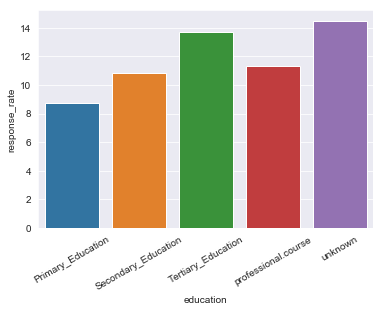

In [27]:
ax = sns.barplot(x='education', y='response_rate', data=agg_education)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

we can notice that the response rate is lowest for people with highest education qualification as primary education, which may be attributed, in part, to lack of awareness and a lack of trust between the bank and the customer. It is the highest for people with tertiary education.

## Default

In [28]:
print(marketing.default.value_counts())
print('*'*40)
print(round(100*marketing.default.value_counts()/len(marketing),2))

no         32588
unknown     8597
yes            3
Name: default, dtype: int64
****************************************
no         79.12
unknown    20.87
yes         0.01
Name: default, dtype: float64


In [29]:
count_prospects_default = marketing.groupby('default')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_default = marketing.groupby('default')['response'].count().reset_index(name = 'No_of_prospects')
agg_default = count_prospects_default.merge(No_of_prospect_default, on = 'default')
agg_default['response_rate'] = 100*(agg_default['count_prospects']/agg_default['No_of_prospects']).round(4)
agg_default

,default,count_prospects,No_of_prospects,response_rate
0,no,4197,32588,12.88
1,unknown,443,8597,5.15
2,yes,0,3,0.00


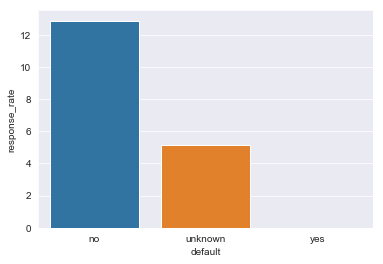

In [30]:
ax = sns.barplot(x='default', y='response_rate', data=agg_default)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

## housing

In [31]:
print(marketing.housing.value_counts())
print('*'*40)
print(round(100*marketing.housing.value_counts()/len(marketing),2))

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
****************************************
yes        52.38
no         45.21
unknown     2.40
Name: housing, dtype: float64


In [32]:
count_prospects_housing = marketing.groupby('housing')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_housing = marketing.groupby('housing')['response'].count().reset_index(name = 'No_of_prospects')
agg_housing = count_prospects_housing.merge(No_of_prospect_housing, on = 'housing')
agg_housing['response_rate'] = 100*(agg_housing['count_prospects']/agg_housing['No_of_prospects']).round(4)
agg_housing

,housing,count_prospects,No_of_prospects,response_rate
0,no,2026,18622,10.88
1,unknown,107,990,10.81
2,yes,2507,21576,11.62


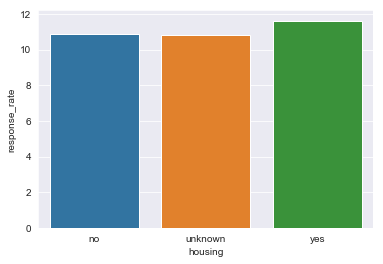

In [33]:
ax = sns.barplot(x='housing', y='response_rate', data=agg_housing)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can see that there is a slight uptick in the response rate for people with housing, though it is probably not very significant

## Loan

In [34]:
print(marketing.loan.value_counts())
print('*'*40)
print(round(100*marketing.loan.value_counts()/len(marketing),2))

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
****************************************
no         82.43
yes        15.17
unknown     2.40
Name: loan, dtype: float64


In [35]:
count_prospects_loan = marketing.groupby('loan')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_loan = marketing.groupby('loan')['response'].count().reset_index(name = 'No_of_prospects')
agg_loan = count_prospects_loan.merge(No_of_prospect_loan, on = 'loan')
agg_loan['response_rate'] = 100*(agg_loan['count_prospects']/agg_loan['No_of_prospects']).round(4)
agg_loan

,loan,count_prospects,No_of_prospects,response_rate
0,no,3850,33950,11.34
1,unknown,107,990,10.81
2,yes,683,6248,10.93


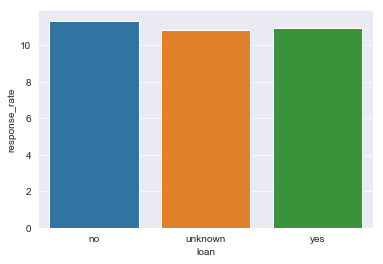

In [36]:
ax = sns.barplot(x='loan', y='response_rate', data=agg_loan)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

As you can see there seems to be very little correlation between a prospect having a personal loan and the likelihood of him/her responding positively to the investment product

## contact

In [37]:
print(marketing.contact.value_counts())
print('*'*40)
print(round(100*marketing.contact.value_counts()/len(marketing),2))

cellular     26144
telephone    15044
Name: contact, dtype: int64
****************************************
cellular     63.47
telephone    36.53
Name: contact, dtype: float64


In [38]:
count_prospects_contact = marketing.groupby('contact')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_contact = marketing.groupby('contact')['response'].count().reset_index(name = 'No_of_prospects')
agg_contact = count_prospects_contact.merge(No_of_prospect_contact, on = 'contact')
agg_contact['response_rate'] = 100*(agg_contact['count_prospects']/agg_contact['No_of_prospects']).round(4)
agg_contact

,contact,count_prospects,No_of_prospects,response_rate
0,cellular,3853,26144,14.74
1,telephone,787,15044,5.23


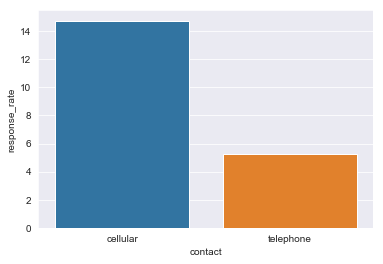

In [39]:
ax = sns.barplot(x='contact', y='response_rate', data=agg_contact)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can see that the prospective customers contacted through cellular medium are significantly ore likely to opt in to the investment scheme compared to customers contacted through telephonic medium.

## Month

In [40]:
print(marketing.month.value_counts())
print('*'*40)
print(round(100*marketing.month.value_counts()/len(marketing),2))

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64
****************************************
may    33.43
jul    17.42
aug    15.00
jun    12.91
nov     9.96
apr     6.39
oct     1.74
sep     1.38
mar     1.33
dec     0.44
Name: month, dtype: float64


In [41]:
count_prospects_month = marketing.groupby('month')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_month = marketing.groupby('month')['response'].count().reset_index(name = 'No_of_prospects')
agg_month = count_prospects_month.merge(No_of_prospect_month, on = 'month')
agg_month['response_rate'] = 100*(agg_month['count_prospects']/agg_month['No_of_prospects']).round(4)
agg_month

,month,count_prospects,No_of_prospects,response_rate
0,apr,539,2632,20.48
1,aug,655,6178,10.60
2,dec,89,182,48.90
3,jul,649,7174,9.05
4,jun,559,5318,10.51
5,mar,276,546,50.55
6,may,886,13769,6.43
7,nov,416,4101,10.14
8,oct,315,718,43.87
9,sep,256,570,44.91


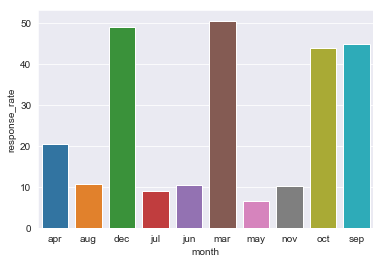

In [42]:
ax = sns.barplot(x='month', y='response_rate', data=agg_month)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can note that the four months of december, march, october and september appear to be the best to contact the potential customers. However, please note that these our months have the fewest data entries as well, so it is not certain, how well it would behave when calls are made at a high volume.

## Day of the week

In [43]:
print(marketing.day_of_week.value_counts())
print('*'*40)
print(round(100*marketing.day_of_week.value_counts()/len(marketing),2))

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64
****************************************
thu    20.94
mon    20.67
wed    19.75
tue    19.64
fri    19.00
Name: day_of_week, dtype: float64


In [44]:
count_prospects_day = marketing.groupby('day_of_week')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_day = marketing.groupby('day_of_week')['response'].count().reset_index(name = 'No_of_prospects')
agg_day = count_prospects_day.merge(No_of_prospect_day, on = 'day_of_week')
agg_day['response_rate'] = 100*(agg_day['count_prospects']/agg_day['No_of_prospects']).round(4)
agg_day

,day_of_week,count_prospects,No_of_prospects,response_rate
0,fri,846,7827,10.81
1,mon,847,8514,9.95
2,thu,1045,8623,12.12
3,tue,953,8090,11.78
4,wed,949,8134,11.67


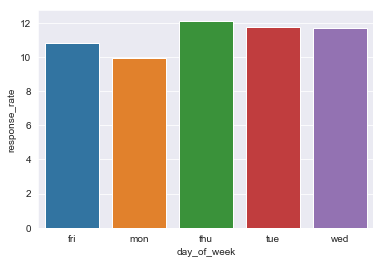

In [45]:
ax = sns.barplot(x='day_of_week', y='response_rate', data=agg_day)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

As you can note that response rate is lowest on monday, while being highest on thursday. However, the gap isn't very big.

## Duration of the call

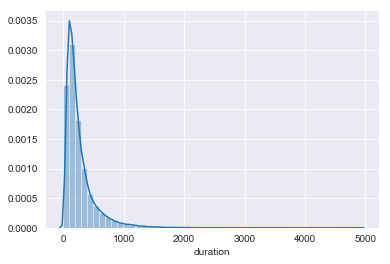

In [46]:
sns.distplot(marketing.duration)
plt.show()

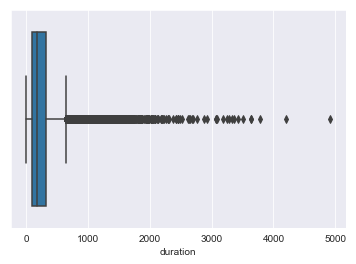

In [47]:
sns.boxplot(x='duration',data = marketing)
plt.show()

In [48]:
marketing.duration.describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [49]:
marketing['duration'][marketing['duration']>1271] =1271

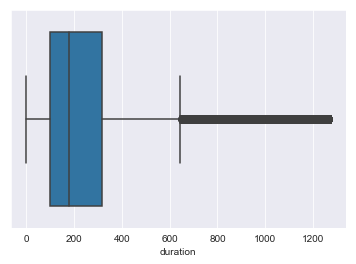

In [50]:
sns.boxplot(x='duration',data = marketing)
plt.show()

## campaign

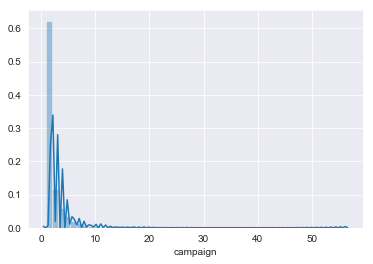

In [51]:
sns.distplot(marketing.campaign)
plt.show()

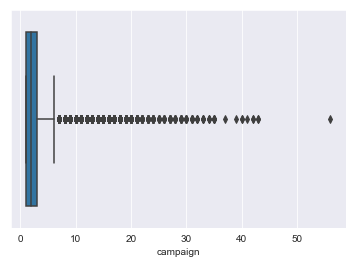

In [52]:
# We will create a box plot
sns.boxplot(x='campaign', data=marketing)
plt.show()

In [53]:
marketing.campaign.describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
95%          7.000000
99%         14.000000
max         56.000000
Name: campaign, dtype: float64

Once again, we can merga all data entries with contacts greater than 14 as having campaign contact as 14

In [54]:
marketing.loc[marketing.campaign>14,'campaign'] = 14

In [55]:
count_prospects_campaign = marketing.groupby('campaign')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_campaign = marketing.groupby('campaign')['response'].count().reset_index(name = 'No_of_prospects')
agg_campaign = count_prospects_campaign.merge(No_of_prospect_campaign, on = 'campaign')
agg_campaign['response_rate'] = 100*(agg_campaign['count_prospects']/agg_campaign['No_of_prospects']).round(4)
agg_campaign

,campaign,count_prospects,No_of_prospects,response_rate
0,1,2300,17642,13.04
1,2,1211,10570,11.46
2,3,574,5341,10.75
3,4,249,2651,9.39
4,5,120,1599,7.50
5,6,75,979,7.66
6,7,38,629,6.04
7,8,17,400,4.25
8,9,17,283,6.01
9,10,12,225,5.33


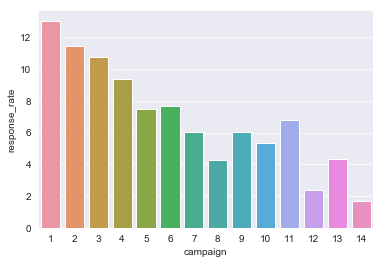

In [56]:
ax = sns.barplot(x='campaign', y='response_rate', data=agg_campaign)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

Interesting to note, that the response rate gradually decreases as the number of campaign contacts increases.

## Gap after the last contact

In [57]:
marketing.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

We are going to divide the pdays into three buckets, that is contacted within the first ten days, contacted after first ten days and first time contacted. Note that the pdays value of 999 means client was bot previously contacted.

In [58]:
marketing['pdays'][marketing['pdays'].isin([0,1,2,3,4,5,6,7,8,9,10])]='Contacted_in_first_10days'
marketing['pdays'][marketing['pdays'].isin([999])]='First_time_contacted'
marketing['pdays'][~marketing['pdays'].isin(['Contacted_in_first_10days','First_time_contacted'])]='Contacted_after_10days'
marketing['pdays'].value_counts()

First_time_contacted         39673
Contacted_in_first_10days     1311
Contacted_after_10days         204
Name: pdays, dtype: int64

In [59]:
count_prospects_pdays = marketing.groupby('pdays')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_pdays = marketing.groupby('pdays')['response'].count().reset_index(name = 'No_of_prospects')
agg_pdays = count_prospects_pdays.merge(No_of_prospect_pdays, on = 'pdays')
agg_pdays['response_rate'] = 100*(agg_pdays['count_prospects']/agg_pdays['No_of_prospects']).round(4)
agg_pdays

,pdays,count_prospects,No_of_prospects,response_rate
0,Contacted_after_10days,116,204,56.86
1,Contacted_in_first_10days,851,1311,64.91
2,First_time_contacted,3673,39673,9.26


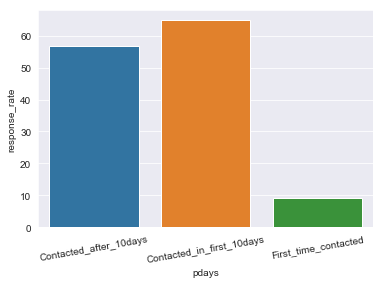

In [60]:
ax = sns.barplot(x='pdays', y='response_rate', data=agg_pdays)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
plt.show()

Though there is a huge difference in the response rates of the three categories, it is important to note that there is also a huge difference in the volume of data entries in these categories

## Previous

In [61]:
marketing.previous.value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

Since the data ranges from 0 to 7, we are going to break it into three categories, that is never contacted, contacted less than three times and contacted greater than three times

In [62]:
marketing['previous'][marketing['previous'].isin([0])]='Never contacted'
marketing['previous'][marketing['previous'].isin([1,2,3])]='Less_than_3_times'
marketing['previous'][marketing['previous'].isin([4,5,6,7])]='More than_3_times'

In [63]:
marketing.previous.value_counts()

Never contacted      35563
Less_than_3_times     5531
More than_3_times       94
Name: previous, dtype: int64

In [64]:
count_prospects_previous = marketing.groupby('previous')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_previous = marketing.groupby('previous')['response'].count().reset_index(name = 'No_of_prospects')
agg_previous = count_prospects_previous.merge(No_of_prospect_previous, on = 'previous')
agg_previous['response_rate'] = 100*(agg_previous['count_prospects']/agg_previous['No_of_prospects']).round(4)
agg_previous

,previous,count_prospects,No_of_prospects,response_rate
0,Less_than_3_times,1445,5531,26.13
1,More than_3_times,54,94,57.45
2,Never contacted,3141,35563,8.83


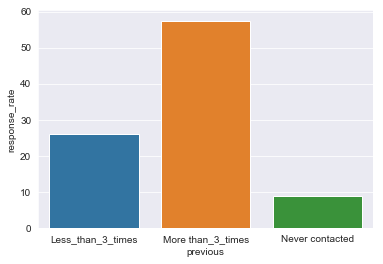

In [65]:
ax = sns.barplot(x='previous', y='response_rate', data=agg_previous)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

## Employment Variation rate

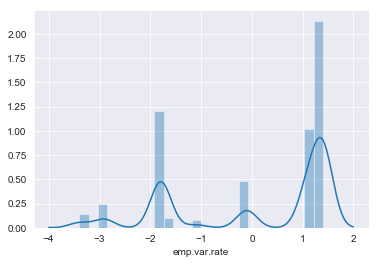

In [66]:
sns.distplot(marketing['emp.var.rate'])
plt.show()

In [67]:
marketing['emp.var.rate'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
95%          1.400000
99%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

In [68]:
marketing['emp.var.rate'].value_counts()

 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

In [69]:
count_prospects_emp_var_rate = marketing.groupby('emp.var.rate')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_emp_var_rate = marketing.groupby('emp.var.rate')['response'].count().reset_index(name = 'No_of_prospects')
agg_emp_var_rate = count_prospects_emp_var_rate.merge(No_of_prospect_emp_var_rate, on = 'emp.var.rate')
agg_emp_var_rate['response_rate'] = 100*(agg_emp_var_rate['count_prospects']/agg_emp_var_rate['No_of_prospects']).round(4)
agg_emp_var_rate

,emp.var.rate,count_prospects,No_of_prospects,response_rate
0,-3.4,454,1071,42.39
1,-3.0,88,172,51.16
2,-2.9,594,1663,35.72
3,-1.8,1461,9184,15.91
4,-1.7,403,773,52.13
5,-1.1,301,635,47.40
6,-0.2,1,10,10.00
7,-0.1,232,3683,6.30
8,1.1,240,7763,3.09
9,1.4,866,16234,5.33


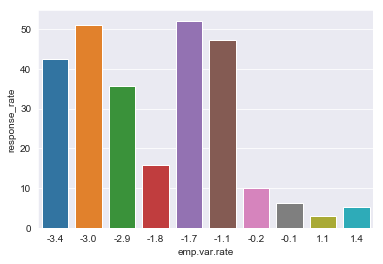

In [70]:
ax = sns.barplot(x='emp.var.rate', y='response_rate', data=agg_emp_var_rate)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can note that a negative employment variation rate seems to be related to higher response rates.

## Consumer Price Index

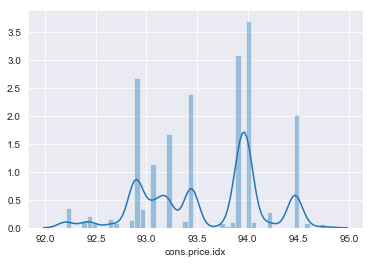

In [71]:
sns.distplot(marketing['cons.price.idx'])
plt.show()

In [72]:
print(marketing['cons.price.idx'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99]))
print('*'*40)
print(marketing['cons.conf.idx'].value_counts())

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
95%         94.465000
99%         94.465000
max         94.767000
Name: cons.price.idx, dtype: float64
****************************************
-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64


## Euribor three month rate

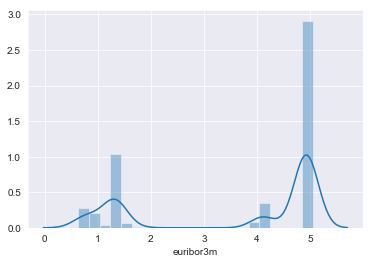

In [73]:
sns.distplot(marketing['euribor3m'])
plt.show()

In [74]:
marketing['euribor3m'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
95%          4.966000
99%          4.968000
max          5.045000
Name: euribor3m, dtype: float64

## Number of Employees

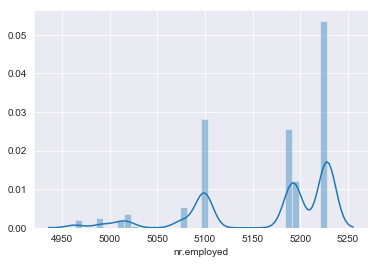

In [75]:
sns.distplot(marketing['nr.employed'])
plt.show()

In [76]:
print(marketing['nr.employed'].value_counts())
print('*'*40)
marketing['nr.employed'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64
****************************************


count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
95%       5228.100000
99%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

Now that we have completed basic exploratory analysis, we can move to the next stage, that is data cleaning and data preparation

## Checpoint 1 : Data preparation

In [77]:
marketing.drop('age_bins',axis = 1,inplace = True)

In [78]:
# Creating a dummy variable for the variable 'job' and dropping the first one.
job = pd.get_dummies(marketing['job'],prefix='job',drop_first=True)
marketing = pd.concat([marketing,job],axis=1)

# Creating dummy variable for marital column
marital = pd.get_dummies(marketing['marital'],prefix='marital',drop_first=True)
marketing = pd.concat([marketing,marital],axis=1)

# Creating dummy variable for education column
education = pd.get_dummies(marketing['education'],prefix='education',drop_first=True)
marketing = pd.concat([marketing,education],axis=1)

# Creating dummy variable for default column
default = pd.get_dummies(marketing['default'],prefix='default',drop_first=True)
marketing = pd.concat([marketing,default],axis=1)

# Creating dummy variable for housing column
housing = pd.get_dummies(marketing['housing'],prefix='housing',drop_first=True)
marketing = pd.concat([marketing,housing],axis=1)

# Creating dummy variable for loan column
loan_v= pd.get_dummies(marketing['loan'],prefix='loan',drop_first=True)
marketing = pd.concat([marketing,loan_v],axis=1)

# Creating dummy variable for contact column
contact = pd.get_dummies(marketing['contact'],prefix='contact',drop_first=True)
marketing = pd.concat([marketing,contact],axis=1)

# Creating dummy variable for month column
month = pd.get_dummies(marketing['month'],prefix='month',drop_first=True)
marketing = pd.concat([marketing,month],axis=1)

# Creating dummy variable for day_of_week column
day_of_week = pd.get_dummies(marketing['day_of_week'],prefix='day_of_week',drop_first=True)
marketing = pd.concat([marketing,day_of_week],axis=1)

# Creating dummy variable for pdays column
pdays = pd.get_dummies(marketing['pdays'],prefix='pdays',drop_first=True)
marketing = pd.concat([marketing,pdays],axis=1)

# Creating dummy variable for previous column
previous = pd.get_dummies(marketing['previous'],prefix='previous',drop_first=True)
marketing = pd.concat([marketing,previous],axis=1)

# Creating dummy variable for poutcome column
poutcome = pd.get_dummies(marketing['poutcome'],prefix='poutcome',drop_first=True)
marketing = pd.concat([marketing,poutcome],axis=1)

marketing.drop(columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','pdays','previous','poutcome'], inplace=True)

marketing.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response,job_blue-collar,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
0,56,261,1,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,0,0,0,1,0,1,1,0
1,57,149,1,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,0,0,0,1,0,1,1,0
2,37,226,1,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,0,0,0,1,0,1,1,0
3,40,151,1,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,0,0,0,1,0,1,1,0
4,56,307,1,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,0,0,0,1,0,1,1,0


### creating prospect id

In [79]:
marketing['prospect_id'] = range(1,len(marketing)+1)
## setting prospect id as index
marketing.set_index('prospect_id',inplace = True)

### creating dataframe with duration and prospect_id

In [80]:
duration = marketing.duration.reset_index()
duration.head()

,prospect_id,duration
0,1,261
1,2,149
2,3,226
3,4,151
4,5,307


### Dropping duration column

In [81]:
marketing.drop('duration',axis =1,inplace = True)

### Spiliting into train test data

In [82]:
X = marketing.drop('response',axis = 1)
y = marketing.response

In [83]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

### Standardizing train and test data

#### train data

In [84]:
X_train_df = X_train[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
norm_mean = X_train_df.mean()
norm_std = X_train_df.std()

In [85]:
std_X_train_df=(X_train_df-norm_mean)/norm_std
X_train = X_train.drop(['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'], 1)
X_train = pd.concat([X_train,std_X_train_df],axis=1)
X_train.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,previous_Never contacted,poutcome_nonexistent,poutcome_success,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
prospect_id,,,,,,,,,,,,,,,,,,,,,
39076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-1.072922,0.211959,-1.962600,-1.490897,1.621426,-1.678536,-1.978312
34856,0,0,0,0,0,0,0,0,1,0,...,1,1,0,-1.072922,0.645301,-1.198745,-1.180389,-1.226553,-1.366757,-0.936166
7108,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0.496306,-0.221383,0.647239,0.718889,0.887856,0.713692,0.330676
31615,0,0,0,0,0,0,1,0,0,0,...,0,0,0,-0.582538,-0.654725,-1.198745,-1.180389,-1.226553,-1.322381,-0.936166
34879,0,0,0,0,0,0,0,0,0,0,...,1,1,0,-0.778691,2.812012,-1.198745,-1.180389,-1.226553,-1.366757,-0.936166


#### test data

In [86]:
# Standardisation with train_set mean and std
X_test_df = X_test[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
std_X_test_df= (X_test_df-norm_mean)/norm_std
X_test = X_test.drop(['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'], 1)
X_test = pd.concat([X_test,std_X_test_df],axis=1)
X_test.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,previous_Never contacted,poutcome_nonexistent,poutcome_success,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
prospect_id,,,,,,,,,,,,,,,,,,,,,
32885,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1.673227,-0.654725,-1.198745,-1.180389,-1.226553,-1.338518,-0.936166
3170,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1.477074,-0.221383,0.647239,0.718889,0.887856,0.713692,0.330676
32207,1,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.680615,-0.654725,-1.198745,-1.180389,-1.226553,-1.330450,-0.936166
9404,0,0,0,0,0,0,0,0,0,0,...,1,1,0,-0.386384,0.645301,0.838203,1.531387,-0.277227,0.775357,0.842100
14021,0,0,1,0,0,0,0,0,0,0,...,1,1,0,-1.269075,-0.221383,0.838203,0.587785,-0.471407,0.773052,0.842100


## Checkpoint 2: Logistic regression

#### model1: model with all features

In [87]:
lr1 = sm.GLM(y_train,sm.add_constant(X_train),family = sm.families.Binomial())
lr1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28782
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7919.9
Date:                Tue, 05 Nov 2019   Deviance:                       15840.
Time:                        20:42:44   Pearson chi2:                 2.93e+04
No. Iterations:                    19   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.4678      0.284     -5.172      0.000      -2.024      -0.912
job_blue-collar                    -0.1152      0.082     -1.397      0.162      -0.277       0.046
job_entrepreneur                   -0.0790      0.129     -0.610      0.542      -0.333       0.175
job_housemaid                      -0.2128      0.157     -1.353      0.176      -0.521       0.095
job_management                     -0.0843      0.091     -0.930      0.352      -0.262       0.093
job_retired                         0.1870      0.112      1.666      0.096      -0.033       0.407
job_self-employed                  -0.1670      0.124     -1.352      0.176      -0.409       0.075
job_services                       -0.1080      0.089     -1.209      0.227      -0.283       0.067
job_student                         0.1421      0.119      1.196      0.232      -0.091       0.375
job_technician                      0.0144      0.074      0.194      0.846      -0.131       0.159
job_unemployed                      0.0086      0.133      0.065      0.948      -0.253       0.270
job_unknown                        -0.4337      0.268     -1.621      0.105      -0.958       0.091
marital_married                     0.0385      0.072      0.538      0.591      -0.102       0.179
marital_single                      0.0331      0.082      0.405      0.686      -0.127       0.193
education_Secondary_Education       0.0146      0.073      0.201      0.841      -0.128       0.157
education_Tertiary_Education        0.1450      0.074      1.968      0.049       0.001       0.289
education_professional.course       0.0187      0.087      0.215      0.830      -0.151       0.189
education_unknown                   0.0060      0.113      0.053      0.958      -0.215       0.227
default_unknown                    -0.2115      0.069     -3.069      0.002      -0.347      -0.076
default_yes                       -17.5858   1.25e+04     -0.001      0.999   -2.45e+04    2.45e+04
housing_unknown                    -0.0277      0.070     -0.397      0.691      -0.164       0.109
housing_yes                        -0.0578      0.043     -1.337      0.181      -0.142       0.027
loan_unknown                       -0.0277      0.070     -0.397      0.691      -0.164       0.109
loan_yes                            0.0460      0.059      0.778      0.437      -0.070       0.162
contact_telephone                  -0.8124      0.081     -9.970      0.000      -0.972      -0.653
month_aug                           0.4373      0.129      3.399      0.001       0.185       0.690
month_dec                           0.3491      0.224      1.562      0.118      -0.089       0.787
month_jul                           0.0330      0.100      0.329      0.742      -0.163       0.229
month_jun                          -0.6521      0.133     -4.9

There are multiple features whose p values is > 0.05. Therefore we can drop such columns. We are going to use RFE to select features.

#### selection top 20 features

In [88]:
lr_20 = LogisticRegression(class_weight='balanced',random_state = 42)
rfe_20 = RFE(lr_20,20)
rfe_20.fit(X_train,y_train)


RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=20, step=1, verbose=0)

In [89]:
cols20 = X_train.columns[rfe_20.support_].tolist() 
print('selected columns:\n')
print(cols20)

selected columns:

['job_housemaid', 'job_student', 'job_unknown', 'default_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'day_of_week_mon', 'pdays_First_time_contacted', 'previous_More than_3_times', 'previous_Never contacted', 'poutcome_nonexistent', 'poutcome_success', 'emp.var.rate', 'cons.price.idx', 'euribor3m']


In [90]:
lr_20 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_20.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28811
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 05 Nov 2019   Deviance:                          nan
Time:                        20:42:56   Pearson chi2:                 2.88e+04
No. Iterations:                   100   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.2531      0.225     -5.569      0.000      -1.694      -0.812
job_housemaid                 -0.2406      0.149     -1.618      0.106      -0.532       0.051
job_student                    0.1579      0.104      1.521      0.128      -0.046       0.361
job_unknown                   -0.4537      0.262     -1.734      0.083      -0.967       0.059
default_yes                -8.685e+06   4.75e+07     -0.183      0.855   -1.02e+08    8.43e+07
contact_telephone             -0.7503      0.071    -10.549      0.000      -0.890      -0.611
month_aug                      0.5180      0.078      6.642      0.000       0.365       0.671
month_dec                      0.2650      0.196      1.350      0.177      -0.120       0.650
month_jun                     -0.5804      0.083     -7.012      0.000      -0.743      -0.418
month_mar                      1.3093      0.117     11.187      0.000       1.080       1.539
month_may                     -0.5426      0.064     -8.415      0.000      -0.669      -0.416
month_nov                     -0.6298      0.085     -7.403      0.000      -0.796      -0.463
day_of_week_mon               -0.3120      0.054     -5.765      0.000      -0.418      -0.206
pdays_First_time_contacted    -1.2197      0.226     -5.387      0.000      -1.663      -0.776
previous_More than_3_times    -0.2027      0.289     -0.702      0.482      -0.768       0.363
previous_Never contacted       0.3361      0.352      0.954      0.340      -0.355       1.027
poutcome_nonexistent           0.2077      0.352      0.589      0.556      -0.483       0.898
poutcome_success               0.7090      0.228      3.105      0.002       0.261       1.157
emp.var.rate                  -2.4827      0.151    -16.392      0.000      -2.780      -2.186
cons.price.idx                 1.0290      0.058     17.783      0.000       0.916       1.142
euribor3m                      1.0514      0.126      8.318      0.000       0.804       1.299
==============================================================================================
"""

### VIF

In [91]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
poutcome_nonexistent,inf
previous_Never contacted,inf
emp.var.rate,75.353580
euribor3m,51.001421
pdays_First_time_contacted,14.988601
cons.price.idx,11.375404
contact_telephone,4.746972
month_may,3.320484
month_aug,2.583025
month_jun,2.319354


dropping `poutcome_nonexistent` because it has large VIF and large pvalue

## Dropping poutcome_nonexistent 

In [92]:
cols20.remove('poutcome_nonexistent')

In [93]:
lr_19 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_19.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28811
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7963.0
Date:                Tue, 05 Nov 2019   Deviance:                       15926.
Time:                        20:42:57   Pearson chi2:                 2.88e+04
No. Iterations:                    19   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.2531      0.225     -5.569      0.000      -1.694      -0.812
job_housemaid                 -0.2406      0.149     -1.616      0.106      -0.532       0.051
job_student                    0.1579      0.104      1.521      0.128      -0.046       0.361
job_unknown                   -0.4537      0.262     -1.732      0.083      -0.967       0.060
default_yes                  -17.5321   1.25e+04     -0.001      0.999   -2.46e+04    2.45e+04
contact_telephone             -0.7503      0.071    -10.537      0.000      -0.890      -0.611
month_aug                      0.5180      0.078      6.636      0.000       0.365       0.671
month_dec                      0.2650      0.196      1.349      0.177      -0.120       0.650
month_jun                     -0.5805      0.083     -7.004      0.000      -0.743      -0.418
month_mar                      1.3093      0.117     11.184      0.000       1.080       1.539
month_may                     -0.5426      0.065     -8.405      0.000      -0.669      -0.416
month_nov                     -0.6298      0.085     -7.396      0.000      -0.797      -0.463
day_of_week_mon               -0.3120      0.054     -5.759      0.000      -0.418      -0.206
pdays_First_time_contacted    -1.2197      0.226     -5.388      0.000      -1.663      -0.776
previous_More than_3_times    -0.2027      0.288     -0.702      0.482      -0.768       0.363
previous_Never contacted       0.5438      0.068      8.016      0.000       0.411       0.677
poutcome_success               0.7090      0.228      3.105      0.002       0.261       1.156
emp.var.rate                  -2.4827      0.152    -16.377      0.000      -2.780      -2.186
cons.price.idx                 1.0291      0.058     17.770      0.000       0.916       1.143
euribor3m                      1.0514      0.127      8.310      0.000       0.803       1.299
==============================================================================================
"""

### VIF

In [94]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
emp.var.rate,75.353580
euribor3m,51.001421
pdays_First_time_contacted,14.988601
previous_Never contacted,11.874114
cons.price.idx,11.375404
contact_telephone,4.746972
month_may,3.320484
month_aug,2.583025
month_jun,2.319354
month_nov,1.921395


## Dropping default_yes

In [95]:
cols20.remove('default_yes')

In [96]:
lr_18 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_18.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28812
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7963.1
Date:                Tue, 05 Nov 2019   Deviance:                       15926.
Time:                        20:42:58   Pearson chi2:                 2.88e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.2532      0.225     -5.569      0.000      -1.694      -0.812
job_housemaid                 -0.2405      0.149     -1.616      0.106      -0.532       0.051
job_student                    0.1579      0.104      1.521      0.128      -0.046       0.361
job_unknown                   -0.4536      0.262     -1.732      0.083      -0.967       0.060
contact_telephone             -0.7502      0.071    -10.536      0.000      -0.890      -0.611
month_aug                      0.5179      0.078      6.635      0.000       0.365       0.671
month_dec                      0.2650      0.196      1.349      0.177      -0.120       0.650
month_jun                     -0.5805      0.083     -7.004      0.000      -0.743      -0.418
month_mar                      1.3093      0.117     11.183      0.000       1.080       1.539
month_may                     -0.5426      0.065     -8.405      0.000      -0.669      -0.416
month_nov                     -0.6299      0.085     -7.398      0.000      -0.797      -0.463
day_of_week_mon               -0.3120      0.054     -5.758      0.000      -0.418      -0.206
pdays_First_time_contacted    -1.2199      0.226     -5.388      0.000      -1.664      -0.776
previous_More than_3_times    -0.2026      0.288     -0.702      0.482      -0.768       0.363
previous_Never contacted       0.5439      0.068      8.018      0.000       0.411       0.677
poutcome_success               0.7090      0.228      3.105      0.002       0.261       1.156
emp.var.rate                  -2.4828      0.152    -16.378      0.000      -2.780      -2.186
cons.price.idx                 1.0291      0.058     17.771      0.000       0.916       1.143
euribor3m                      1.0514      0.127      8.310      0.000       0.803       1.299
==============================================================================================
"""

### VIF

In [97]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
emp.var.rate,75.353579
euribor3m,51.001285
pdays_First_time_contacted,14.986580
previous_Never contacted,11.872292
cons.price.idx,11.375401
contact_telephone,4.746949
month_may,3.320481
month_aug,2.582943
month_jun,2.319350
month_nov,1.921286


## Dropping emp.var.rate

In [98]:
cols20.remove('emp.var.rate')

In [99]:
lr_17 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_17.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8092.9
Date:                Tue, 05 Nov 2019   Deviance:                       16186.
Time:                        20:42:59   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.1358      0.221     -5.131      0.000      -1.570      -0.702
job_housemaid                 -0.1883      0.147     -1.283      0.199      -0.476       0.099
job_student                    0.2326      0.103      2.269      0.023       0.032       0.433
job_unknown                   -0.2678      0.257     -1.041      0.298      -0.772       0.236
contact_telephone             -0.3636      0.064     -5.652      0.000      -0.490      -0.238
month_aug                      0.0455      0.070      0.647      0.517      -0.092       0.183
month_dec                      0.4741      0.195      2.437      0.015       0.093       0.855
month_jun                      0.0482      0.074      0.646      0.518      -0.098       0.194
month_mar                      0.7773      0.114      6.833      0.000       0.554       1.000
month_may                     -0.9709      0.058    -16.603      0.000      -1.086      -0.856
month_nov                     -0.1392      0.079     -1.765      0.078      -0.294       0.015
day_of_week_mon               -0.3176      0.053     -5.938      0.000      -0.422      -0.213
pdays_First_time_contacted    -1.4196      0.222     -6.383      0.000      -1.855      -0.984
previous_More than_3_times    -0.1465      0.288     -0.509      0.611      -0.711       0.418
previous_Never contacted       0.5392      0.066      8.131      0.000       0.409       0.669
poutcome_success               0.6231      0.224      2.779      0.005       0.184       1.063
cons.price.idx                 0.2007      0.027      7.454      0.000       0.148       0.253
euribor3m                     -0.9709      0.029    -33.277      0.000      -1.028      -0.914
==============================================================================================
"""

### VIF

In [100]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
pdays_First_time_contacted,14.718344
previous_Never contacted,11.859087
cons.price.idx,4.046494
contact_telephone,3.777277
euribor3m,3.601199
month_may,3.137526
month_jun,2.107789
month_aug,2.027908
month_nov,1.657557
poutcome_success,1.313211


## Dropping pdays_First_time_contacted

In [101]:
cols20.remove('pdays_First_time_contacted')

In [102]:
lr_16 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_16.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28814
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8113.0
Date:                Tue, 05 Nov 2019   Deviance:                       16226.
Time:                        20:43:00   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.4784      0.071    -34.913      0.000      -2.617      -2.339
job_housemaid                 -0.1938      0.147     -1.320      0.187      -0.481       0.094
job_student                    0.2659      0.102      2.614      0.009       0.067       0.465
job_unknown                   -0.2547      0.257     -0.992      0.321      -0.758       0.248
contact_telephone             -0.3623      0.064     -5.637      0.000      -0.488      -0.236
month_aug                      0.0724      0.070      1.033      0.302      -0.065       0.210
month_dec                      0.4720      0.194      2.435      0.015       0.092       0.852
month_jun                      0.0432      0.074      0.581      0.561      -0.102       0.189
month_mar                      0.7812      0.113      6.889      0.000       0.559       1.003
month_may                     -0.9781      0.058    -16.745      0.000      -1.093      -0.864
month_nov                     -0.1262      0.079     -1.603      0.109      -0.281       0.028
day_of_week_mon               -0.3144      0.053     -5.888      0.000      -0.419      -0.210
previous_More than_3_times     0.1334      0.293      0.455      0.649      -0.441       0.708
previous_Never contacted       0.4557      0.064      7.140      0.000       0.331       0.581
poutcome_success               1.9341      0.092     21.007      0.000       1.754       2.115
cons.price.idx                 0.2142      0.027      8.009      0.000       0.162       0.267
euribor3m                     -0.9841      0.029    -33.903      0.000      -1.041      -0.927
==============================================================================================
"""

### VIF

In [103]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
cons.price.idx,4.035945
contact_telephone,3.771004
euribor3m,3.353547
previous_Never contacted,3.341325
month_may,2.838058
month_jun,2.034711
month_aug,1.862232
month_nov,1.450672
poutcome_success,1.245238
day_of_week_mon,1.241692


## Dropping previous_More than_3_times	

In [104]:
cols20.remove('previous_More than_3_times')

In [105]:
lr_15 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_15.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28815
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8113.1
Date:                Tue, 05 Nov 2019   Deviance:                       16226.
Time:                        20:43:01   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4774      0.071    -34.921      0.000      -2.616      -2.338
job_housemaid               -0.1930      0.147     -1.316      0.188      -0.481       0.095
job_student                  0.2670      0.102      2.626      0.009       0.068       0.466
job_unknown                 -0.2558      0.257     -0.996      0.319      -0.759       0.248
contact_telephone           -0.3629      0.064     -5.647      0.000      -0.489      -0.237
month_aug                    0.0748      0.070      1.071      0.284      -0.062       0.212
month_dec                    0.4720      0.194      2.435      0.015       0.092       0.852
month_jun                    0.0428      0.074      0.575      0.565      -0.103       0.188
month_mar                    0.7815      0.113      6.892      0.000       0.559       1.004
month_may                   -0.9772      0.058    -16.740      0.000      -1.092      -0.863
month_nov                   -0.1242      0.079     -1.581      0.114      -0.278       0.030
day_of_week_mon             -0.3146      0.053     -5.891      0.000      -0.419      -0.210
previous_Never contacted     0.4542      0.064      7.128      0.000       0.329       0.579
poutcome_success             1.9364      0.092     21.062      0.000       1.756       2.117
cons.price.idx               0.2161      0.026      8.176      0.000       0.164       0.268
euribor3m                   -0.9854      0.029    -34.128      0.000      -1.042      -0.929
============================================================================================
"""

## Dropping month_jun

In [106]:
cols20.remove('month_jun')

In [107]:
lr_14 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_14.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28816
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8113.2
Date:                Tue, 05 Nov 2019   Deviance:                       16226.
Time:                        20:43:01   Pearson chi2:                 3.07e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4701      0.070    -35.416      0.000      -2.607      -2.333
job_housemaid               -0.1936      0.147     -1.319      0.187      -0.481       0.094
job_student                  0.2670      0.102      2.625      0.009       0.068       0.466
job_unknown                 -0.2538      0.257     -0.989      0.323      -0.757       0.249
contact_telephone           -0.3506      0.060     -5.796      0.000      -0.469      -0.232
month_aug                    0.0674      0.069      0.982      0.326      -0.067       0.202
month_dec                    0.4634      0.193      2.398      0.016       0.085       0.842
month_mar                    0.7731      0.112      6.876      0.000       0.553       0.993
month_may                   -0.9874      0.056    -17.770      0.000      -1.096      -0.879
month_nov                   -0.1323      0.077     -1.712      0.087      -0.284       0.019
day_of_week_mon             -0.3142      0.053     -5.884      0.000      -0.419      -0.210
previous_Never contacted     0.4546      0.064      7.132      0.000       0.330       0.579
poutcome_success             1.9369      0.092     21.066      0.000       1.757       2.117
cons.price.idx               0.2176      0.026      8.273      0.000       0.166       0.269
euribor3m                   -0.9860      0.029    -34.205      0.000      -1.042      -0.929
============================================================================================
"""

## Dropping month_aug

In [108]:
cols20.remove('month_aug')

In [109]:
lr_13 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_13.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28817
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8113.7
Date:                Tue, 05 Nov 2019   Deviance:                       16227.
Time:                        20:43:01   Pearson chi2:                 3.07e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4502      0.067    -36.767      0.000      -2.581      -2.320
job_housemaid               -0.1912      0.147     -1.304      0.192      -0.479       0.096
job_student                  0.2721      0.101      2.681      0.007       0.073       0.471
job_unknown                 -0.2518      0.257     -0.980      0.327      -0.755       0.252
contact_telephone           -0.3557      0.060     -5.904      0.000      -0.474      -0.238
month_dec                    0.4456      0.192      2.316      0.021       0.068       0.823
month_mar                    0.7597      0.112      6.810      0.000       0.541       0.978
month_may                   -1.0025      0.053    -18.785      0.000      -1.107      -0.898
month_nov                   -0.1534      0.074     -2.068      0.039      -0.299      -0.008
day_of_week_mon             -0.3147      0.053     -5.895      0.000      -0.419      -0.210
previous_Never contacted     0.4526      0.064      7.110      0.000       0.328       0.577
poutcome_success             1.9437      0.092     21.208      0.000       1.764       2.123
cons.price.idx               0.2089      0.025      8.422      0.000       0.160       0.258
euribor3m                   -0.9767      0.027    -35.835      0.000      -1.030      -0.923
============================================================================================
"""

## Dropping job_unknown

In [110]:
cols20.remove('job_unknown')

In [111]:
lr_12 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_12.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28818
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8114.2
Date:                Tue, 05 Nov 2019   Deviance:                       16228.
Time:                        20:43:01   Pearson chi2:                 3.07e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4520      0.067    -36.805      0.000      -2.583      -2.321
job_housemaid               -0.1892      0.147     -1.290      0.197      -0.477       0.098
job_student                  0.2742      0.101      2.703      0.007       0.075       0.473
contact_telephone           -0.3562      0.060     -5.913      0.000      -0.474      -0.238
month_dec                    0.4460      0.193      2.317      0.021       0.069       0.823
month_mar                    0.7605      0.112      6.818      0.000       0.542       0.979
month_may                   -1.0015      0.053    -18.772      0.000      -1.106      -0.897
month_nov                   -0.1516      0.074     -2.045      0.041      -0.297      -0.006
day_of_week_mon             -0.3146      0.053     -5.894      0.000      -0.419      -0.210
previous_Never contacted     0.4523      0.064      7.106      0.000       0.328       0.577
poutcome_success             1.9413      0.092     21.192      0.000       1.762       2.121
cons.price.idx               0.2090      0.025      8.427      0.000       0.160       0.258
euribor3m                   -0.9767      0.027    -35.838      0.000      -1.030      -0.923
============================================================================================
"""

## Dropping job_housemaid

In [112]:
cols20.remove('job_housemaid')

In [113]:
lr_11 = sm.GLM(y_train,sm.add_constant(X_train[cols20]),family = sm.families.Binomial())
lr_11.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28819
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8115.1
Date:                Tue, 05 Nov 2019   Deviance:                       16230.
Time:                        20:43:01   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4568      0.067    -36.932      0.000      -2.587      -2.326
job_student                  0.2784      0.101      2.746      0.006       0.080       0.477
contact_telephone           -0.3561      0.060     -5.912      0.000      -0.474      -0.238
month_dec                    0.4388      0.193      2.279      0.023       0.061       0.816
month_mar                    0.7623      0.112      6.834      0.000       0.544       0.981
month_may                   -0.9998      0.053    -18.748      0.000      -1.104      -0.895
month_nov                   -0.1512      0.074     -2.039      0.041      -0.297      -0.006
day_of_week_mon             -0.3147      0.053     -5.896      0.000      -0.419      -0.210
previous_Never contacted     0.4520      0.064      7.101      0.000       0.327       0.577
poutcome_success             1.9392      0.092     21.171      0.000       1.760       2.119
cons.price.idx               0.2084      0.025      8.407      0.000       0.160       0.257
euribor3m                   -0.9771      0.027    -35.863      0.000      -1.031      -0.924
============================================================================================
"""

### VIF

In [114]:
X = X_train[cols20]
pd.DataFrame([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(by =0,ascending = False)

,0
contact_telephone,3.128822
cons.price.idx,2.902488
euribor3m,2.417599
previous_Never contacted,2.332753
month_may,2.083972
month_nov,1.249816
day_of_week_mon,1.238559
poutcome_success,1.152082
month_mar,1.066043
job_student,1.052044


All pvalues and VIFs are in acceptable range

## Using grid search for hyper parameter tuning

In [115]:
logistic = LogisticRegression(class_weight='balanced',random_state = 42)
params = [{'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'penalty': ['l1', 'l2']}]
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc')
model.fit(X_train[cols20],y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [116]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.785004661030428
Best hyperparameters:  {'C': 2, 'penalty': 'l1'}


## Train set metrics

In [117]:
# predict churn on test data
y_pred = model.predict(X_train[cols20])

# create onfusion matrix
cm = confusion_matrix(y_train, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_train[cols20])[:, 1]
print("AUC:    \t", round(roc_auc_score(y_train, y_pred_prob),2))

[[20233  5347]
 [ 1068  2183]]
Sensitivity: 	0.67
Specificity: 	0.79
AUC:    	 0.79


## test set metrics

In [118]:
# predict churn on test data
y_pred = model.predict(X_test[cols20])

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test[cols20])[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[8659 2309]
 [ 473  916]]
Sensitivity: 	0.66
Specificity: 	0.79
AUC:    	 0.78


## Finding optimal Cutoff point

In [119]:
y_train_prob_pred = model.predict_proba(X_train[cols20])

In [120]:
y_train_prob_pred[:5]

array([[0.24032122, 0.75967878],
       [0.53867921, 0.46132079],
       [0.84976048, 0.15023952],
       [0.59084579, 0.40915421],
       [0.47570593, 0.52429407]])

In [121]:
# taking probability for response = 1, which is second column
prob_df = pd.DataFrame(y_train_prob_pred[:,1],index = X_train.index).reset_index().rename(columns = {0:'probability'})

In [122]:
prob_df = prob_df.sort_values(by='probability',ascending = False)
prob_df = prob_df.merge(y_train.reset_index(),on='prospect_id')
prob_df.head()

,prospect_id,probability,response
0,39341,0.986816,1
1,39337,0.986802,1
2,39259,0.986719,1
3,39154,0.986677,1
4,39148,0.986677,1


In [123]:
cut_off = prob_df.copy()
for c in range(1,10):
    cut_off[c/10] = cut_off.probability.apply(lambda x: 1 if x> c/10 else 0)
cut_off.head()

,prospect_id,probability,response,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,39341,0.986816,1,1,1,1,1,1,1,1,1,1
1,39337,0.986802,1,1,1,1,1,1,1,1,1,1
2,39259,0.986719,1,1,1,1,1,1,1,1,1,1
3,39154,0.986677,1,1,1,1,1,1,1,1,1,1
4,39148,0.986677,1,1,1,1,1,1,1,1,1,1


In [124]:
metric_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

num = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(cut_off.response, cut_off[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    metric_df.loc[i] =[ i ,accuracy,sensi,speci]
print(metric_df)

     prob  accuracy     sensi     speci
0.1   0.1  0.112761  1.000000  0.000000
0.2   0.2  0.287226  0.953860  0.202502
0.3   0.3  0.374770  0.908028  0.306998
0.4   0.4  0.726787  0.708705  0.729085
0.5   0.5  0.777496  0.671486  0.790970
0.6   0.6  0.837293  0.608736  0.866341
0.7   0.7  0.864660  0.516149  0.908952
0.8   0.8  0.894835  0.311904  0.968921
0.9   0.9  0.899379  0.186404  0.989992


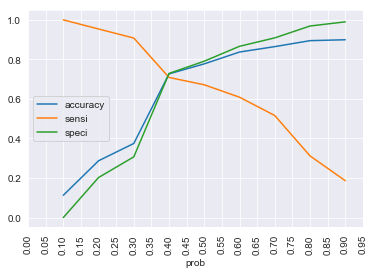

In [125]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
metric_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0,1,0.05))
plt.xticks(rotation='vertical')
plt.show()

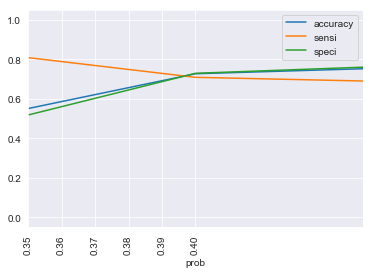

In [126]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
metric_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0.3,0.4,0.01))
plt.xticks(rotation='vertical')
plt.xlim(0.35,0.45)
plt.show()

In [127]:
prob_df['pred_response'] = prob_df.probability.apply(lambda x : 1 if x> 0.395 else 0)

__Optimal cutoff probability is 0.395__.

## ROC curve

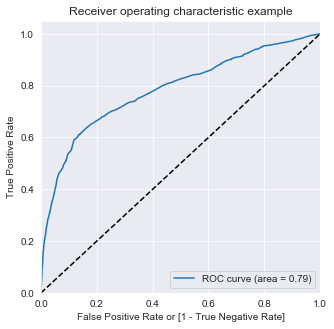

In [128]:
from sklearn import metrics
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve( prob_df.response, prob_df.probability, drop_intermediate = False )

draw_roc(prob_df.response, prob_df.probability)

In [129]:
def print_bold(x):
    print('\033[1m'+str(x)+'\033[0m')

### train set metrics with optimal cutoff

In [130]:
from sklearn.metrics import accuracy_score
# Let's check the overall accuracy.
print_bold('train set accuracy :')
print(accuracy_score(prob_df.response, prob_df.pred_response))

confusion2 = confusion_matrix(prob_df.response, prob_df.pred_response)
print_bold('\ntrain set confusion matrix:')
print(confusion2)

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print_bold('\nSensitivity :')
print(TP / float(TP+FN))

# Let us calculate specificity
print_bold('\nSpecificity :')
print(TN / float(TN+FP))

# Calculate false postive rate 
print_bold('\nFalse poisitive rate :')
print(FP/ float(TN+FP))

# Positive predictive value 
print_bold('\nPositive predictive power :')
print (TP / float(TP+FP))

# Negative predictive value
print_bold('\nNegative predictive power :')
print (TN / float(TN+ FN))

train set accuracy :
0.7261281259755125

train set confusion matrix:
[[18631  6949]
 [  947  2304]]

Sensitivity :
0.7087050138418948

Specificity :
0.7283424550430023

False poisitive rate :
0.2716575449569977

Positive predictive power :
0.24900032421917215

Negative predictive power :
0.9516293799162325


### test set metrics with optimal cutoff

In [131]:
y_test_prob_pred = model.predict_proba(X_test[cols20])
# taking probability for response = 1, which is second column
prob_test_df = pd.DataFrame(y_test_prob_pred[:,1],index = X_test.index).reset_index().rename(columns = {0:'probability'})

prob_test_df = prob_test_df.sort_values(by='probability',ascending = False)
prob_test_df = prob_test_df.merge(y_test.reset_index(),on='prospect_id')
prob_test_df['pred_response'] = prob_test_df.probability.apply(lambda x : 1 if x> 0.395 else 0)
prob_test_df.head()

,prospect_id,probability,response,pred_response
0,39256,0.982973,1,1
1,39393,0.980622,1,1
2,39386,0.980612,1,1
3,39309,0.980531,0,1
4,39287,0.980500,1,1


In [132]:
from sklearn.metrics import accuracy_score
# Let's check the overall accuracy.
print_bold('test set accuracy :')
print(accuracy_score(prob_test_df.response, prob_test_df.pred_response))

print_bold('\ntest set confusion matrix:')
confusion2 = confusion_matrix(prob_test_df.response, prob_test_df.pred_response)
print(confusion2)

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print_bold('\nSensitivity :')
print(TP / float(TP+FN))

# Let us calculate specificity
print_bold('\nSpecificity :')
print(TN / float(TN+FP))

# Calculate false postive rate 
print_bold('\nFalse poisitive rate :')
print(FP/ float(TN+FP))

# Positive predictive value 
print_bold('\nPositive predictive power :')
print (TP / float(TP+FP))

# Negative predictive value
print_bold('\nNegative predictive power :')
print (TN / float(TN+ FN))

test set accuracy :
0.7248523104313345

test set confusion matrix:
[[7982 2986]
 [ 414  975]]

Sensitivity :
0.7019438444924406

Specificity :
0.7277534646243617

False poisitive rate :
0.2722465353756382

Positive predictive power :
0.24614996213077506

Negative predictive power :
0.9506908051453072


train and test set metrics are similar therefore we can use this as the final model

### Metrics for entire dataset

In [133]:
X_final = pd.concat([X_train,X_test],axis = 0).sort_index()
X_final.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,previous_Never contacted,poutcome_nonexistent,poutcome_success,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
prospect_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1.575150,-0.654725,0.647239,0.718889,0.887856,0.711964,0.330676
2,0,0,0,0,0,0,1,0,0,0,...,1,1,0,1.673227,-0.654725,0.647239,0.718889,0.887856,0.711964,0.330676
3,0,0,0,0,0,0,1,0,0,0,...,1,1,0,-0.288308,-0.654725,0.647239,0.718889,0.887856,0.711964,0.330676
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0.005923,-0.654725,0.647239,0.718889,0.887856,0.711964,0.330676
5,0,0,0,0,0,0,1,0,0,0,...,1,1,0,1.575150,-0.654725,0.647239,0.718889,0.887856,0.711964,0.330676


In [134]:
y_final = pd.concat([y_train,y_test],axis = 0).sort_index()
y_final.head()

prospect_id
1    0
2    0
3    0
4    0
5    0
Name: response, dtype: int64

In [135]:
y_final_prob_pred = model.predict_proba(X_final[cols20])
# taking probability for response = 1, which is second column
prob_final_df = pd.DataFrame(y_final_prob_pred[:,1],index = X_final.index).reset_index().rename(columns = {0:'probability'})

prob_final_df = prob_final_df.sort_values(by='probability',ascending = False)
prob_final_df = prob_final_df.merge(y_final.reset_index(),on='prospect_id')
prob_final_df['pred_response'] = prob_final_df.probability.apply(lambda x : 1 if x> 0.395 else 0)
prob_final_df.head()

,prospect_id,probability,response,pred_response
0,39341,0.986816,1,1
1,39337,0.986802,1,1
2,39259,0.986719,1,1
3,39148,0.986677,1,1
4,39154,0.986677,1,1


In [136]:
print_bold('accuracy :')
print(accuracy_score(prob_final_df.response, prob_final_df.pred_response))

confusion2 = confusion_matrix(prob_final_df.response, prob_final_df.pred_response)



print_bold('\nconfusion matrix for entire data:')
print(confusion2)

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print_bold('\nSensitivity :')
print(TP / float(TP+FN))

# Let us calculate specificity
print_bold('\nSpecificity :')
print(TN / float(TN+FP))

# Calculate false postive rate 
print_bold('\nFalse poisitive rate :')
print(FP/ float(TN+FP))

# Positive predictive value 
print_bold('\nPositive predictive power :')
print (TP / float(TP+FP))

# Negative predictive value
print_bold('\nNegative predictive power :')
print (TN / float(TN+ FN))

0.7257453627270078
accuracy :

confusion matrix for entire data:
[[26613  9935]
 [ 1361  3279]]

Sensitivity :
0.7066810344827587

Specificity :
0.7281656999014994

False poisitive rate :
0.2718343000985006

Positive predictive power :
0.24814590585742394

Negative predictive power :
0.9513476799885608


## Checkpoint 3

Assuming that cost of call is 1 paisa per second.

In [137]:
duration_pred = prob_final_df.merge(duration,on='prospect_id')
duration_pred = duration_pred.merge(marketing.campaign.reset_index(),on='prospect_id')
duration_pred['cost_of_call_in_Rs'] = duration_pred.duration/100
duration_pred.head()

,prospect_id,probability,response,pred_response,duration,campaign,cost_of_call_in_Rs
0,39341,0.986816,1,1,101,1,1.01
1,39337,0.986802,1,1,136,1,1.36
2,39259,0.986719,1,1,215,1,2.15
3,39148,0.986677,1,1,313,1,3.13
4,39154,0.986677,1,1,363,1,3.63


## Checkpoint 4

__Goal is to reach 80% of responders.__

In [138]:
decile_df = duration_pred.copy()

In [139]:
decile_df['decile'] = pd.qcut(decile_df['probability'], 10, labels=np.arange(10, 0, -1))
decile_df.head()

,prospect_id,probability,response,pred_response,duration,campaign,cost_of_call_in_Rs,decile
0,39341,0.986816,1,1,101,1,1.01,1
1,39337,0.986802,1,1,136,1,1.36,1
2,39259,0.986719,1,1,215,1,2.15,1
3,39148,0.986677,1,1,313,1,3.13,1
4,39154,0.986677,1,1,363,1,3.63,1


In [140]:
lift_df = decile_df.groupby('decile')['probability'].count().reset_index()

In [141]:
lift_df

,decile,probability
0,10,5661
1,9,2695
2,8,4489
3,7,3721
4,6,4479
5,5,3943
6,4,3962
7,3,4256
8,2,3884
9,1,4098


In [142]:
lift_df.rename({'probability':'total'}, axis=1, inplace=True)

In [143]:
lift_df_pred = decile_df[decile_df['response']==1].groupby('decile')['response'].count().reset_index()

In [144]:
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')

In [145]:
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

In [146]:
lift_df_final['cumresp'] = lift_df_final['response'].cumsum()

In [147]:
lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['response']))

In [148]:
lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))

In [149]:
lift_df_final = lift_df_final.merge(decile_df.groupby('decile').duration.sum().reset_index(),on='decile')

In [150]:
lift_df_final = lift_df_final.merge(decile_df.groupby('decile').campaign.sum().reset_index(),on='decile')

In [151]:
lift_df_final

,decile,total,response,cumresp,gain,cumlift,duration,campaign
0,1,4098,2020,2020,43.534483,4.353448,1189485,7659
1,2,3884,819,2839,61.185345,3.059267,1044115,7467
2,3,4256,396,3235,69.719828,2.323994,1083972,10263
3,4,3962,246,3481,75.021552,1.875539,1003041,8520
4,5,3943,258,3739,80.581897,1.611638,1083679,11409
5,6,4479,175,3914,84.353448,1.405891,1001609,14590
6,7,3721,234,4148,89.396552,1.277094,898509,9647
7,8,4489,217,4365,94.073276,1.175916,1016262,12934
8,9,2695,91,4456,96.034483,1.067050,672548,5947
9,10,5661,184,4640,100.000000,1.000000,1482916,14535


Our goal is to reach 80% of the responders. If we target the people is top 5 deciles ordered according to decreasing predicted probability, then we can contact 80.58% of the responders. __Hence We are required to contact Top 5 deciles.__

#### Average call duration for 5 deciles

In [152]:
print_bold('Average call duration for top 5 deciles:')
print(lift_df_final.loc[lift_df_final.decile >6,'duration'].sum()/lift_df_final.loc[lift_df_final.decile >6,'total'].sum())

Average call duration for top 5 deciles:
268.2962815866554


__The average call duration for top 4 deciles is 268.29 seconds, which is about 4.5 minutes.__

## Checkpoint 5: Lift and gain chart

## Gain chart

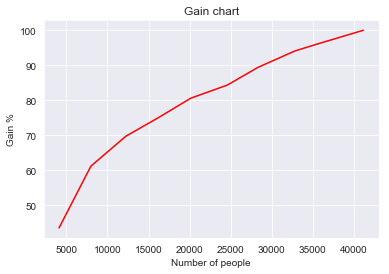

In [163]:
plt.plot(lift_df_final['total'].cumsum(),lift_df_final['gain'],'r')
plt.title('Gain chart')
plt.xlabel('Number of people')
plt.ylabel('Gain %')
plt.show()

## Lift Chart

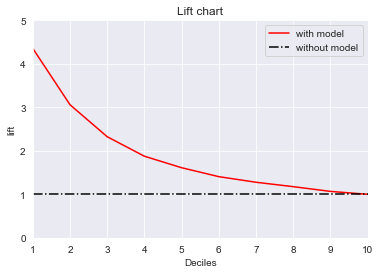

In [164]:
plt.plot(lift_df_final.decile.tolist(),lift_df_final.cumlift.tolist(),color='r',label = 'with model')
plt.axhline(y=1, color='k', linestyle='-.',label = 'without model')
plt.legend()
plt.xlim([1,10])
plt.ylim([0,5])
plt.title('Lift chart')
plt.xlabel('Deciles')
plt.ylabel('lift')
plt.show()

## Checkpoint 6:

### Cost wrt number of contacts made

In [155]:
print_bold('Number of contacts made in top 5 deciles:')
print(lift_df_final.loc[lift_df_final.decile >6,'campaign'].sum())

Number of contacts made in top 5 deciles:
45318


In [156]:
print_bold('percentage of contacts made in top 5 deciles:')
print(45318/lift_df_final.campaign.sum())

percentage of contacts made in top 5 deciles:
0.4401044954404638


In [157]:
print_bold('Total contacts made:')
print(lift_df_final.campaign.sum())

Total contacts made:
102971


The cost incured is determined as 1\*number of contacts made. There since we are looking for 80% of the responders, we are only required to contact top 5 deciles, which turns out to be 45318. __Therefore the cost incured is 45318.__ <br>
When compared to the total cost which is __102971__, when have __reduced the cost to about 44%__ using the logistic regression model. We have gained a __56% reduction in cost.__

### Cost wrt the duration of phonecall

Assumptions:
- Total duration is calculated as number of contacts * average call duration
- Average call time remains same for all the contacts across all the calls, although this assumption is not true it gives a rough idea about cost incured
- Average call cost for top 5 deciles is calculated seperately
- Call cost is considered as 1 paisa per second

In [158]:
print('Average duration of call in seconds for all the people:')
print(lift_df_final.duration.sum()/len(y_final))
print('Number of contacts made in total:')
print(lift_df_final.campaign.sum())
print('Total duration spent for all the calls:')
print(lift_df_final.campaign.sum()*lift_df_final.duration.sum()/len(y_final))
print_bold('Assuming cost of the call is 1 paisa per second')
print('Total cost fot contating all people(in Rs):')
print(lift_df_final.campaign.sum()*lift_df_final.duration.sum()/(len(y_final)*100))
total_cost = lift_df_final.campaign.sum()*lift_df_final.duration.sum()/(len(y_final)*100)

Average duration of call in seconds for all the people:
254.3492279304652
Number of contacts made in total:
102971
Total duration spent for all the calls:
26190594.34922793
Assuming cost of the call is 1 paisa per second
Total cost fot contating all people(in Rs):
261905.9434922793


In [159]:
print_bold('we are required to contact only top 5 deciles to acheive that tagert of 80%, therefore')
print('Average call duration top 5 deciles:')
avg_dur = lift_df_final.loc[lift_df_final.decile >6,'duration'].sum()/lift_df_final.loc[lift_df_final.decile >6,'total'].sum()
print(avg_dur)
print('Number of contacts made in top 5 decile:')
print(lift_df_final.loc[lift_df_final.decile >6,'campaign'].sum())
print('cost fot contating top 5 deciles people(in Rs):')
print(avg_dur*lift_df_final.loc[lift_df_final.decile >6,'campaign'].sum()/100)
top_5_cost = avg_dur*lift_df_final.loc[lift_df_final.decile >6,'campaign'].sum()/100
print_bold('final cost as fraction of intial cost:')
print(round(100*top_5_cost/total_cost,2))

we are required to contact only top 5 deciles to acheive that tagert of 80%, therefore
Average call duration top 5 deciles:
268.2962815866554
Number of contacts made in top 5 decile:
45318
cost fot contating top 5 deciles people(in Rs):
121586.5088894405
final cost as fraction of intial cost:
46.42


The cost incured is determined as 1\*average_call_duration\*number_of_contacts_made. Therefore since we are looking for 80% of the responders, we are only required to contact top 5 deciles, which turns out to be __121586.50 Rs.__ 
When compared to the total cost which is __261905.94 Rs__, when have __reduced the cost to about 46%__ using the logistic regression model. We have gained a __54% reduction in cost.__

## Final model parameters and obervations

In [160]:
final_model = model.best_estimator_
formula = str(round(final_model.intercept_[0],3))
for i,j in zip(X_train[cols20].columns,final_model.coef_.reshape(-1,).tolist()):
    if j > 0:
        formula = formula+ ' + '+str(round(j,3))+'\033[1m'+' x '+'\033[0m'+str(i)
    else:
        formula = formula+' '+str(round(j,3))+'\033[1m'+' x '+'\033[0m'+str(i)

print_bold('Logistic regression equation:')
print(formula)

Logistic regression equation:
-0.42 + 0.392 x job_student -0.252 x contact_telephone + 0.523 x month_dec + 0.834 x month_mar -0.956 x month_may -0.189 x month_nov -0.233 x day_of_week_mon + 0.424 x previous_Never contacted + 1.984 x poutcome_success + 0.182 x cons.price.idx -0.924 x euribor3m


In [161]:
for i,j in zip(X_train[cols20].columns,final_model.coef_.reshape(-1,).tolist()):
    if j > 0 :
        val = '\033[1m'+str(round(j,3))+'\033[0m'
        var = '\033[92m'+'\033[1m'+str(i)+'\033[0m'
    else :
        val = '\033[1m'+str(round(j,3))+'\033[0m'
        var = '\033[91m'+'\033[1m'+str(i)+'\033[0m'
    print('{message: <40}'.format(message=var),' : ','{message: >15}'.format(message=val))

job_student                  :    0.392
contact_telephone            :   -0.252
month_dec                    :    0.523
month_mar                    :    0.834
month_may                    :   -0.956
month_nov                    :   -0.189
day_of_week_mon              :   -0.233
previous_Never contacted     :    0.424
poutcome_success             :    1.984
cons.price.idx               :    0.182
euribor3m                    :   -0.924


The final model has 11 features that effect the response. The variable in green effect the output positively where as the variable in red effect the output negatively. 
- `Poutcome_success` has the largest positive impact whereas `month_may` and `euribor3m` has the largest negative impact.
- We can see that festive months dec and mar have high positive correlation
- Monday seems to a strong variable that effects negatively the response.